In [14]:
import copy
import math
import pickle
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from numpy import asarray
import matplotlib.pyplot as plt
import krippendorff

import sys
import os
sys.path.append((str(Path(os.getcwd()).parent) + '/src').replace("\\", "/"))
import sorting_algorithms as sa

Fetching data

In [15]:
def get_annotation_df():
    
    anno_paths = ['Hybrid', 'RankVsSort']
    df = pd.DataFrame(columns=['file', 'alg', 'user', 'csv', 'sort_alg', 'anno_path'])
    
    for anno_path in anno_paths:

        csv_paths = [str(f) for f in list(Path(anno_path).glob('**/*.csv'))]
        pickle_paths = [str(f) for f in list(Path(anno_path).glob('**/*.pickle'))]

        filenames = [Path(f).stem for f in csv_paths]

        for f in set(filenames):

            csv_path = sorted([path for path in csv_paths if f in path])[-1]
            csv = pd.read_csv(csv_path)
            user = csv.iloc[0]['user']

            pickle_path = sorted([path for path in pickle_paths if f in path])[-1]
            pickle_file = pickle.load(open(pickle_path, 'rb'))
            sort_alg = pickle_file['sort_alg']

            alg = type(sort_alg)

            df.loc[len(df)] = [f, alg, user, csv, sort_alg, anno_path]

    return df

annotation_df = get_annotation_df()

In [16]:
def recompute_algorithms(annotation_df, anno_path="RankVsSort"):

    rmses = [[],[],[],[],[],[]]

    df_ts = annotation_df[(annotation_df['alg'] == sa.TrueSkill) & (annotation_df['anno_path'] == anno_path)].reset_index()
    

    all_ranks = [[],[],[],[],[],[]]
    
    for i, row in df_ts.iterrows():

        if anno_path == "Hybrid":

            ratings = annotation_df[(annotation_df['alg'] == sa.RatingAlgorithm) & (annotation_df['user'] == row['user'][:-1]) ].reset_index()

            rating_df = ratings.loc[ratings.index[0]]["csv"]
            mu_dict = {}
            for _, rating_row in rating_df.iterrows():
                rating = rating_row['rating']
                mu_dict[rating_row['src']] = 25 + ((rating - 2) * 2 + 1) / 4 * 8.333

            sort_alg = sa.TrueSkill(data=row['sort_alg'].data, comparison_max=row['sort_alg'].comparison_max, initial_mus = mu_dict)

        else:

            sort_alg = sa.TrueSkill(data=row['sort_alg'].data, comparison_max=row['sort_alg'].comparison_max)
            
        counter = -1

        for j, i_df in row['csv'].iterrows():
            res = i_df['result'].replace("[", "").replace("]", "").replace("'", "").split(", ")
            res =  [r.replace("\\\\", "\\") for r in res]

            keys = sort_alg.get_comparison(i_df['user'])

            diff_lvls = [sa.DiffLevel(abs([int(s) for s in dl if s.isdigit()][0])) for dl in i_df['diff_levels'].split(", ")]

            if i_df['undone'] == True:
                pass
            else:
                counter += 1
                sort_alg.inference(i_df['user'], res, diff_lvls)

                if j > 0:
                    rmse = math.sqrt(
                        sum(
                            (prev_ratings[key].mu - sort_alg.ratings[key].mu) ** 2
                            for key in sort_alg.data) / sort_alg.n)
                    rmses[i].append(rmse)

                prev_ratings = copy.deepcopy(sort_alg.ratings)

                all_ranks[i].append(sort_alg.get_result())
        
    return all_ranks, rmses

all_ranks, rmses = recompute_algorithms(annotation_df)
all_ranks_hybrid, rmses_hybrid = recompute_algorithms(annotation_df, anno_path="Hybrid")

In [17]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def sorted_idx_to_ranks(sorted_idx):
    ranks = {}#np.zeros(len(sorted_idx))

    current_rank = len(sorted_idx)    
    for idx in sorted_idx:
        ranks[idx] = current_rank
        current_rank -= 1

    return ranks

def get_all_ratings():
    rating_results_df = annotation_df[annotation_df['alg'] == sa.RatingAlgorithm].sort_values("user")
    all_ratings = []

    for i, row in rating_results_df.iterrows():
        ratings_dict = row['sort_alg'].get_user_result(row['user'])
        ratings_sorted = [v for _, v in sorted(ratings_dict.items(), key=lambda x:x[0])]

        all_ratings.append(ratings_sorted)
    
    return all_ratings

def get_distr_from_ratings(all_ratings):
    flat_ratings = list(np.array(all_ratings).flat)
    c = Counter(flat_ratings)
    return [c[i]/len(flat_ratings) for i in range(4)]

def get_all_rankings():
    ranking_results_df = annotation_df[annotation_df['alg'] == sa.TrueSkill].sort_values("user")
    all_rankings = []

    for _, row in ranking_results_df.iterrows():

        ranking = row['sort_alg'].get_result()
        all_rankings.append(ranking)
    
    return all_rankings

def rank_2_ratings(all_rankings, distribution):
    
    indexes = [int(np.round(distribution[i]*len(all_rankings[0]))) for i in range(len(distribution))]
    ratings = [i for i in range(len(distribution)) for _ in range(indexes[i])]

    all_ratings = []

    for rankings in all_rankings:
        ratings_dict = dict(zip(rankings, ratings))
        ratings_sorted = [v for _, v in sorted(ratings_dict.items(), key=lambda x:x[0])]

        all_ratings.append(ratings_sorted)

    return all_ratings

In [18]:
def get_alphas(all_ranks):
    alphas = []

    for i in range(min([len(ranks) for ranks in all_ranks])):
        ranks = [all_ranks[user_i][i] for user_i in range(len(all_ranks))]
        
        sorted_ranks = []
        for r in ranks:
            ranks_dict = sorted_idx_to_ranks(r)
            sorted_ranks.append([v for k, v in sorted(ranks_dict.items(), key=lambda x:x[0])])

        ratings = rank_2_ratings(ranks, get_distr_from_ratings(get_all_ratings()))

        alphas.append(krippendorff.alpha(ratings, level_of_measurement="ordinal"))
        

    return alphas

alphas = get_alphas(all_ranks)
alphas_hybrid = get_alphas(all_ranks_hybrid)

Time comparison between ranking and rating

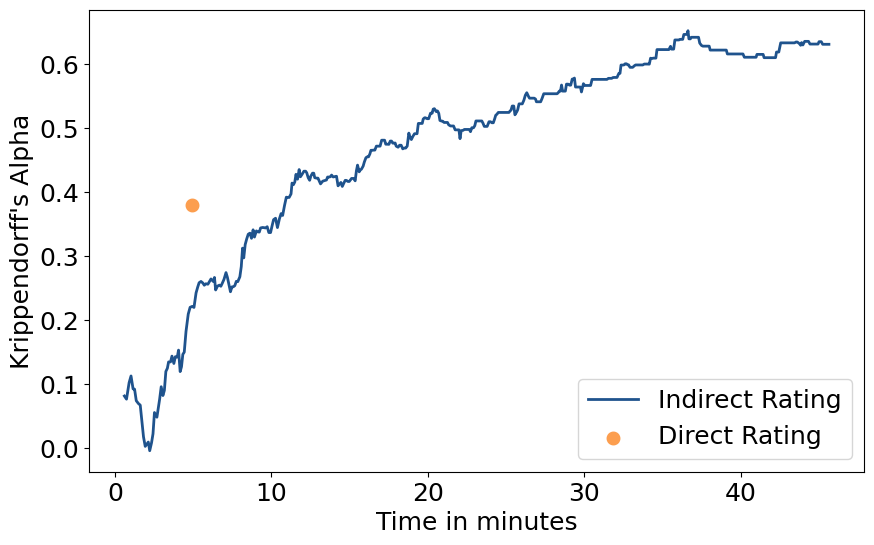

In [19]:
def get_time_array():

    df_ts = annotation_df[annotation_df["alg"] == sa.TrueSkill].reset_index()
    multiple_list = []

    for i, row in df_ts.iterrows():
        user_times = []
        sessions = list(set(row["csv"]["session"].values.tolist()))
        
        for i in range(len(sessions)):
            session_times = row["csv"][row["csv"]["session"] == sessions[i]]["time"].values.tolist()
            user_times += [s_t + max(user_times, default=0) for s_t in session_times]


        multiple_list.append(user_times)

    return [np.mean(k) for k in zip(*multiple_list)]

times = get_time_array()

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 18
lw = 2
plt.plot(np.array(times)/60,alphas, label="Indirect Rating", linewidth=lw, color='#1F538D')
rating_times = [212, 327, 312, 447, 273, 193]
avg_time = np.average(rating_times)

plt.scatter(avg_time/60, 0.38, linewidth=lw*2, marker = 'o', color = '#FC9E4F', label="Direct Rating")
plt.ylabel("Krippendorff's Alpha")
plt.xlabel("Time in minutes")
plt.legend(loc='lower right')
plt.show()

Alpha comparison at given amount of pairwise comparisons

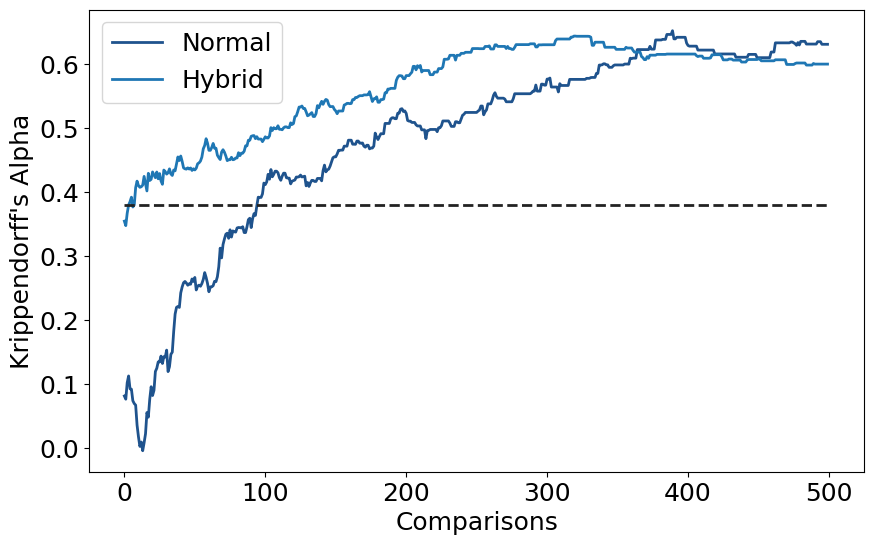

In [20]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 18
lw = 2
plt.plot(alphas, linewidth=lw, color='#1F538D', label="Normal")
plt.plot(alphas_hybrid, linewidth=lw, label="Hybrid")
plt.hlines(0.38, 0, 500, linestyles="--", linewidth=lw, colors="#222222")
plt.ylabel("Krippendorff's Alpha")
plt.xlabel("Comparisons")
plt.legend()
plt.show()

Root mean square error

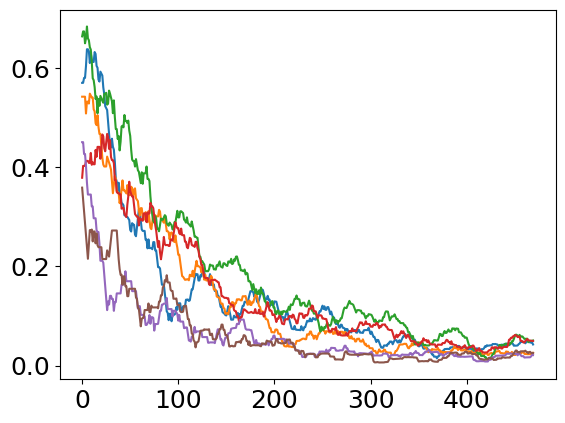

In [21]:
for rmse in rmses:
    plt.plot(moving_average(rmse, 30))
plt.show()

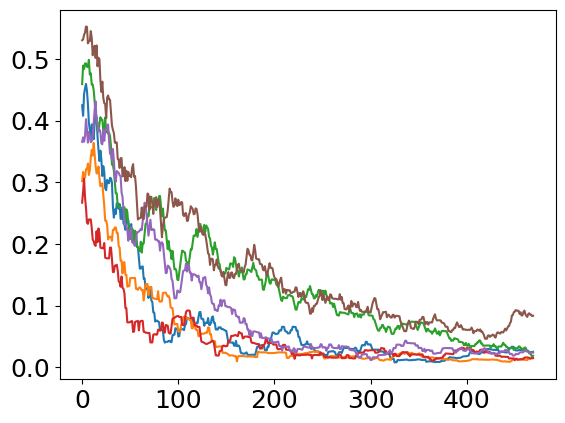

In [22]:
for rmse in rmses_hybrid:
    plt.plot(moving_average(rmse, 30))
plt.show()